In [1]:
%pylab inline

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)


Populating the interactive namespace from numpy and matplotlib


In [2]:
from util import *
from model import *

In [3]:
'''
df_users = read_unique_users
df_tweets = read_tweest()
'''

'\ndf_users = read_unique_users\ndf_tweets = read_tweest()\n'

In [4]:
df_users = read_unique_users(fnames= ['data/run2/users_stream.json']) 
df_tweets = read_tweets( fnames = ['data/run2/tweets_stream.json'] )

read in 11748 users
read in 65950 tweets


In [5]:
print df_tweets.shape
print df_tweets.dtypes

(65950, 9)
created_at        object
created_by        object
favorite_count     int64
hash_tags         object
id_str            object
in_reply_to       object
retweet_count      int64
text              object
urls              object
dtype: object


In [6]:
df_tweets = pre_process_tweets(df_tweets)

In [7]:
pipeline = read_model(fname='model_final.pkl')
txt_lst = df_tweets.str_text
y = pipeline.predict(txt_lst)
print np.sum(y), (np.sum(y))/len(y), len(y)
df_tweets['is_job_opening'] = y

63276.0 0.959454131918 65950


In [8]:
print np.sum(df_tweets['is_job_opening']>0), np.sum(y)
print np.sum(y)

63276 63276.0
63276.0


In [9]:
df_tweets = get_quality_tweets(df_tweets)
df_tweets = df_tweets[ df_tweets['is_job_opening']==1]
df_tweets['hour']=df_tweets['created_at'].apply(lambda x: int(x.split(':')[0].split()[-1])-7)
df_tweets['hour'] = df_tweets['hour'].apply(lambda x: x+24 if x < 0 else x)
df_tweets['user_screen_name'] = df_tweets['created_by']
df_tweets = pd.merge(df_tweets , df_users[['user_location','user_screen_name']], how='left', on='user_screen_name') 

count by str_text mean 1.113 std 0.785 cut_off 3.470
65950 tweets, 59229 unique str_text, 58600 after filtering 
count by created_by mean 5.614 std 12.869 cut_off 44.222
before 65950 after 47853


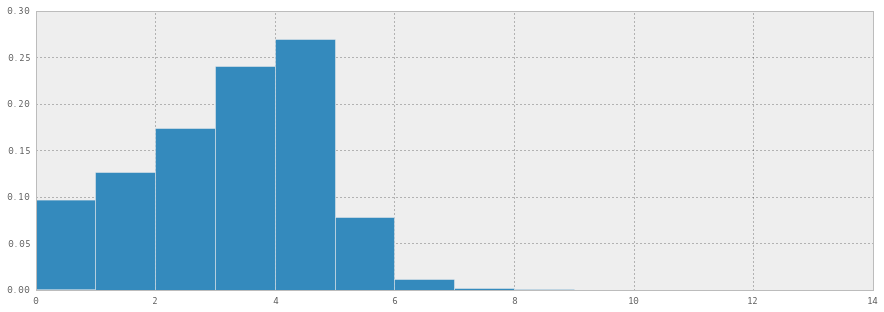

In [10]:
n, bins, patches = plt.hist(df_tweets.n_hashtag,bins=xrange(14), normed = 1)
plt.show()

In [11]:
cnt_by_loc = df_tweets.groupby('user_location')['id_str'].count().sort(ascending=False, inplace=False)
print len(cnt_by_loc)
print cnt_by_loc[:20]
print 1.0*cnt_by_loc[0]/np.sum(cnt_by_loc)
print 'user location:',df_tweets.user_location.nunique()
print 'user_screen_name:',df_tweets.user_screen_name.nunique()

2878
user_location
                    5328
usa                  916
canada               512
united states        456
us                   417
los angeles ca       406
boston ma            392
new york ny          390
san francisco ca     390
california           355
chicago il           350
new york             332
uk                   310
worldwide            309
houston tx           291
phoenix az           287
florida              279
texas                276
united kingdom       260
austin tx            255
Name: id_str, dtype: int64
0.115264797508
user location: 2878
user_screen_name: 10259


In [27]:
cnt_by_loc = df_tweets.groupby('user_screen_name')['id_str'].count().sort(ascending=False, inplace=False)
print len(cnt_by_loc)
print cnt_by_loc[:20]
print 1.0*cnt_by_loc[0]/np.sum(cnt_by_loc)
print 'user_screen_name:',df_tweets.user_location.nunique()


10259
user_screen_name
SpeedwayJobs       42
dressbarnjobs      42
SelectStaffing     42
Hiring_Houston     41
tmj_tx_retail      41
Jobs_Rochester     40
Hire_Colorado      40
JobsinLasVegas1    40
mauricescareers    40
Sunrise_Careers    40
JobsDirectUSA      40
VSIcareers         40
NYC_job            39
MercyJobs          39
Silicon_IT         39
Hiring_Arkansas    39
tmj_ca_retail      39
Recruit_Boston     39
FATZjobs           39
IT_Orlando         38
Name: id_str, dtype: int64
0.000908618899273
user_screen_name: 2878


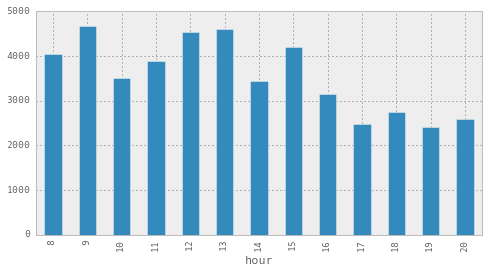

In [12]:
df_tweets.groupby('hour')['id_str'].count().plot(kind='bar', figsize=(8,4))

In [13]:
position_vectorizer = JobCatVecotrizer()
pos_vector = position_vectorizer.get_posi_m(df_tweets.str_text)
job_cats = position_vectorizer.job_categories 

In [14]:
print zip(np.sum(pos_vector, axis = 0),job_cats )
print df_tweets.shape
print pos_vector.shape

[(1424, 'admin'), (2100, 'analysis'), (2039, 'driver'), (5686, 'engineer'), (4452, 'marketing/sales'), (2963, 'medical')]
(46224, 17)
(46224, 6)


In [15]:
s = []
for i in xrange(len(job_cats)):
    cond = pos_vector[:,i] == 1
    cnt_by_loc_cat = df_tweets[cond].groupby('user_location')['id_str'].count().sort(ascending=False, inplace=False)
    #print len(cnt_by_loc_cat)
    print cnt_by_loc_cat[:5]
    s.append(cnt_by_loc_cat)


user_location
                   114
usa                 32
united kingdom      21
leeds england       19
bristol england     19
Name: id_str, dtype: int64
user_location
                 179
usa               47
columbus ohio     33
boston ma         31
united states     27
Name: id_str, dtype: int64
user_location
                  120
wisconsin          41
california usa     34
michigan           34
vermont usa        28
Name: id_str, dtype: int64
user_location
                575
usa             162
worldwide       100
austin texas     67
new york         66
Name: id_str, dtype: int64
user_location
                    553
usa                 124
los angeles ca       64
san francisco ca     64
canada               56
Name: id_str, dtype: int64
user_location
                  351
houston tx         56
texas              45
los angeles ca     44
boston ma          43
Name: id_str, dtype: int64


In [16]:
df_cnt_by_loc = pd.concat(s, axis = 1)
df_cnt_by_loc.columns = job_cats
df_cnt_by_loc = df_cnt_by_loc.fillna(0)
print df_cnt_by_loc.head()
for c in job_cats:
    df_cnt_by_loc[c+'_rank']=df_cnt_by_loc[c].rank(ascending=False)

In [18]:
cols_rank = [c+'_rank' for c in job_cats]
df_cnt_by_loc['rank_best'] = df_cnt_by_loc[cols_rank].apply(lambda x: np.min(x), axis = 1)
cond = df_cnt_by_loc['rank_best'] <5
df_cnt_by_loc[job_cats].sum()

admin              1424
analysis           2100
driver             2039
engineer           5686
marketing/sales    4452
medical            2963
dtype: float64

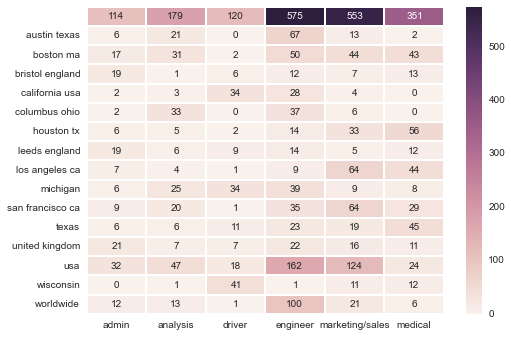

In [19]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
ax = sns.heatmap(df_cnt_by_loc[cond][job_cats], annot=True, fmt=".0f")

In [20]:
cond = df_tweets['created_by'] == 'Go2WebMarketing'
for x in df_tweets[cond].text:
    print x
#print df_tweets[cond]

In [21]:
df_tweets.shape

(46224, 17)

In [22]:
def is_ds(x):
    pat = ['data scientist', 'analyst', 'analytics']
    t = [p in x for p in pat]
    return np.any(t)
cond = map(lambda x: is_ds(x.lower()) , df_tweets.text)

In [23]:
np.any([0,1,0])

True

In [24]:
cond = map(lambda x: 'job #truck #hiring #job #woodland - company drivers - increased starting pay view details #jobs'\
           in x, df_tweets.str_text)

In [25]:
df_tweets[cond].iloc[:5].T

""
created_at
created_by
favorite_count
hash_tags
id_str
in_reply_to
retweet_count
text
urls
str_text


created_at        Thu Aug 13 20:04:31 +0000 2015
is_job_opening                                 1
hour                                          13
Name: 0, dtype: object
"#nepal  #jobs .NET Developer - Synergy Info Systems (SIS) - 18 Days: Company: Synergy Info Systems (SI... http://t.co/FP2Ntc0mky .9774u"
created_at        Thu Aug 13 21:48:03 +0000 2015
is_job_opening                                 1
hour                                          14
Name: 1, dtype: object
"@StudentSpaza: You a Radio Lover? Unemployed? over 18 years? have a valid SA ID? Apply for @Yfm #YAcademy NOW via http://t.co/qgmK2Wrm87"
created_at        Fri Aug 14 01:08:55 +0000 2015
is_job_opening                                 1
hour                                          18
Name: 2, dtype: object
#(AJ) #PKI Certs Administrator needed in #Columbia at AT&amp;T. Apply now! #jobs http://t.co/TmAQYVsGo9
created_at        Fri Aug 14 01:05:27 +0000 2015
is_job_opening                                 1
hour       